In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
import pandas as pd
import numpy as np
import h5py
import joblib

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
import warnings

# 모든 FutureWarning 무시
warnings.simplefilter(action='ignore', category=FutureWarning)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-05-05 12:59:02.116853: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746449942.128002   45346 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746449942.131097   45346 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data Processing

In [6]:
def load_data(filename):
    """
    이미지를 불러옵니다.
    Parameters:
        filename: str
            h5 파일에서 데이터를 불러옵니다.
    Returns:
        np.ndarray, pd.DataFrame, np.ndarray, 
        train 이미지, train spot 정보, test 이미지, test spot 정보
    """
    images, spots = list(), list()
    with h5py.File(filename, "r") as h5file:
        train_images = h5file["images/Train"]
        train_spots = h5file["spots/Train"]
    
        num_train_slides = len(train_images)
        # Train 이미지를 불러옵니다.
        # 하나의 텐서로 만들기 위해 이미지의 크기를 2000x2000으로 균일하게 만듭니다.
        for i, slide_name in enumerate(train_images.keys()):
            image = np.mean(np.array(train_images[slide_name]), axis = -1, keepdims=True)
            image = (np.clip((image - np.min(image)) / (np.max(image) - np.min(image)), 0, 1) * 255).astype('uint8')
            p1 = 2000 - image.shape[0]
            p2 = 2000 - image.shape[1]
            images.append(
                np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge')
            )
            spots.append(pd.DataFrame(np.array(train_spots[slide_name])).assign(slide = i))
            if slide_name == 'S_2':
                spots[-1] = spots[-1].assign(
                    x = lambda x: x['x'] - 60,
                    y = lambda x: x['y'] - 60,
                )
        # Test 이미지를 불러옵니다.
        test_images = h5file["images/Test"]
        test_spots = h5file["spots/Test"]
        sample = 'S_7'
        image = np.mean(np.array(test_images[sample]), axis = -1, keepdims=True)
        image = (np.clip((image - np.min(image)) / (np.max(image) - np.min(image)), 0, 1) * 255).astype('uint8')
        p1 = 2000 - image.shape[0]
        p2 = 2000 - image.shape[1]
        images.append(np.pad(image, [(0, p1), (0, p2), (0, 0)], 'edge'))
        spots.append(pd.DataFrame(np.array(test_spots[sample])).assign(slide = len(spots)))
    # EfficientNet의 형식으로 바꿉니다.
    with tf.device('/CPU:0'):
        images = tf.constant(tf.keras.applications.efficientnet.preprocess_input(images))
    df_spots = pd.concat(spots).reset_index(drop = True)
    return images, df_spots

def make_img_proc_info(df, img_with, img_height):
    return df.assign(
        left = lambda x: x['x'] - img_width // 2,
        right = lambda x: x['x'] + img_width // 2,
        top = lambda x: x['y'] - img_height // 2,
        bottom = lambda x: x['y'] + img_height // 2,
        lpad = lambda x: -(x['left'].where(x['left'] < 0, 0)),
        rpad = lambda x: -(2000 - x['right']).where(x['right'] > 2000, 0),
        tpad = lambda x: -(x['top'].where(x['top'] < 0, 0)),
        bpad = lambda x: -(2000 - x['bottom']).where(x['bottom'] > 2000, 0)
    ).assign(
        left = lambda x: x['left'].clip(0, 2000),
        right = lambda x: x['right'].clip(0, 2000),
        top = lambda x: x['top'].clip(0, 2000),
        bottom = lambda x: x['bottom'].clip(0, 2000),
    )

def create_tf_ds(df):
    if target in df.columns:
        return tf.data.Dataset.from_tensor_slices(
            ({
                i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
            }, df[target] == 6)
        )
    else:
        return tf.data.Dataset.from_tensor_slices({
            i: df[i] for i in ['left', 'right', 'top', 'bottom', 'slide', 'lpad', 'rpad', 'tpad', 'bpad']
        })

def proc_images(X, images):
    return tf.cast(tf.pad(
        images[X['slide'], X['left']:X['right'], X['top']:X['bottom'], :], 
        paddings = [(X['lpad'], X['rpad']), (X['tpad'], X['bpad']), (0, 0)],
        constant_values=1
    ), tf.float32) / 255.0

augmentation_layers = [
    #tf.keras.layers.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.RandomRotation(0.5),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1),
]

def data_augmentation(x):
    for layer in augmentation_layers:
        x = layer(x)
    return x

images, df_spots = load_data("data/elucidata_ai_challenge_data.h5")
target = 'slide'

In [7]:
np.min(images[2]), np.max(images[2])

(0, 255)

In [8]:
np.min(images[0]), np.max(images[0])

(0, 255)

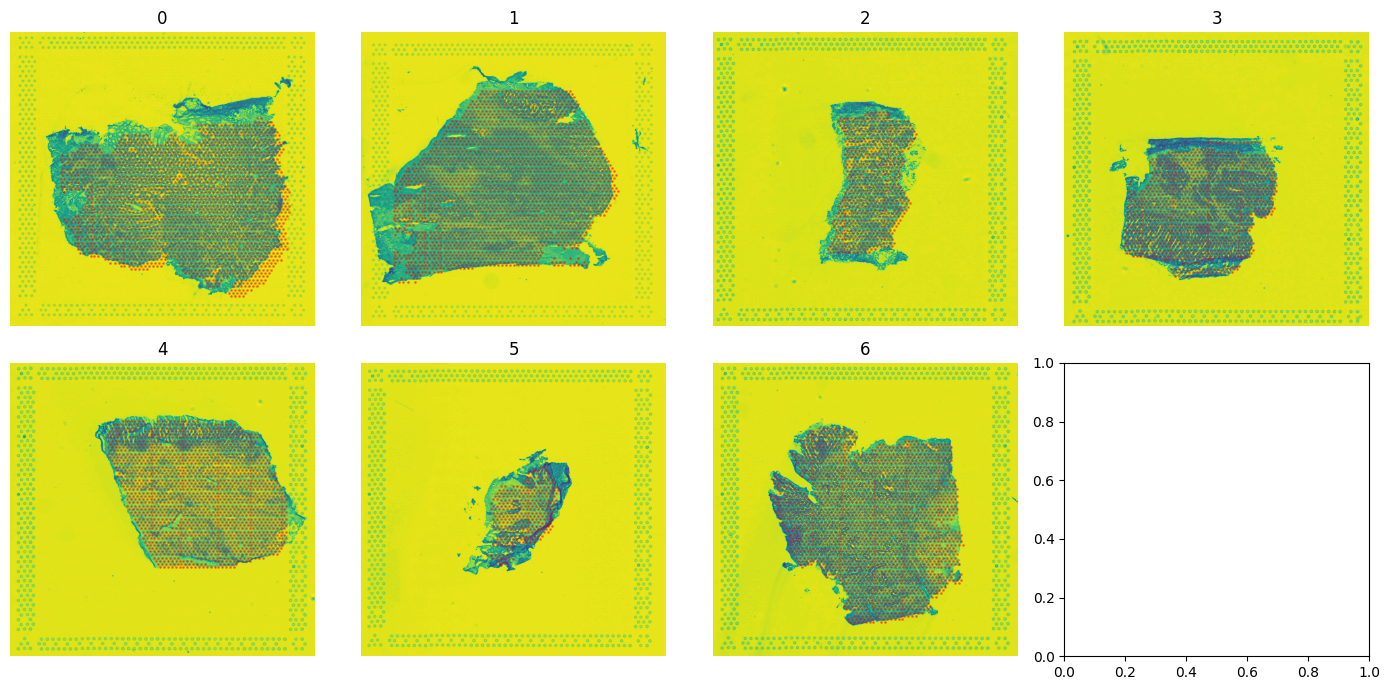

In [20]:
fig, ax = plt.subplots(2, 4, figsize=(14, 7))
ax = ax.flatten()
for i, slide_name in enumerate(range(7)):
    image = images[i]
    x, y = df_spots.loc[df_spots['slide'] == i, "x"], df_spots.loc[df_spots['slide'] == i, "y"]

    ax[i].imshow(image, aspect="auto")
    ax[i].scatter(x, y, color="red", s=1, alpha=0.4)  # Overlay spot locations
    ax[i].set_title(slide_name)
    ax[i].axis('off')

plt.tight_layout()
plt.show()

In [10]:
# 경량화된 MBConv block
def mbconv_block(x, in_channels, out_channels, expand_ratio, strides = 1):
    hidden_dim = in_channels * expand_ratio
    residual = x

    if expand_ratio != 1:
        x = tf.keras.layers.Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual connection (only if shape matches and stride == 1)
    if strides == 1 and in_channels == out_channels:
        x = tf.keras.layers.Add()([x, residual])

    return x

def efficientnet_8x(input_shape=(8, 8, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    x = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = mbconv_block(x, 16, 16, expand_ratio=1)
    x = mbconv_block(x, 16, 24, expand_ratio=2)
    x = mbconv_block(x, 24, 32, expand_ratio=2)

    x = tf.keras.layers.Conv2D(48, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Classification head
    return tf.keras.models.Model(inputs, tf.keras.layers.GlobalAveragePooling2D()(x))

In [11]:
def create_model(img_width, img_height):
    input_shape = (img_width, img_height, 1)
    inputs = tf.keras.Input(shape = input_shape)
    enet_, _ = joblib.load('model/ae_encoder_b0_obj.joblib')
    enet = efficientnet_8x(input_shape)
    #enet.set_weights(enet_)
    enet.trainable = True
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(
        256, activation = 'relu', 
        kernel_initializer = 'HeUniform'
    )
    x = d1(x)
    d2 = tf.keras.layers.Dense(1)
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

In [12]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
img_width = 8
img_height = 8
df_spots = make_img_proc_info(df_spots, img_width, img_height)

gkf = GroupKFold(n_splits = 6)
ssf = StratifiedShuffleSplit(n_splits=1, train_size = 0.8)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    ssf.split(df_spots[['x', 'y']], df_spots[target] == 6)# , groups = df_spots['slide'])
):
    break
m, layers = create_model(img_width, img_height)
m.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 8, 8, 1)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional (Functional)              │ (None, 48)                  │           8,016 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          12,544 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,817 (81.32 KB)

 Trainable params: 20,193 (78.88 KB)

 Non-trainable params: 624 (2.44 KB)

In [13]:
from sklearn.metrics import accuracy_score
learning_rate = 1e-3
#target_proc = FunctionTransformer(lambda x: x, lambda x: x)
batch_size = 32
epochs = 5
step = ''
ds_cv_train = create_tf_ds(
    df_spots.iloc[train_idx].pipe(
        lambda x: pd.concat([
            x, x.sample(n = batch_size - (len(x) % batch_size))
        ])
    )
).shuffle(5000).map(
    lambda X, y: (proc_images(X, images), y)
).map(
    lambda X, y: (data_augmentation(X), y)
).batch(batch_size)


if valid_idx is not None:
    ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
        lambda X, y: (proc_images(X, images), y)
    ).batch(batch_size)
else:
    ds_valid = None
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=3000,
    alpha=0.1
)
#    lr_schedule = learning_rate
m.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Epoch 1/5


I0000 00:00:1746450043.744880   45394 service.cc:148] XLA service 0x7f9e080085b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746450043.744912   45394 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
I0000 00:00:1746450044.130622   45394 cuda_dnn.cc:529] Loaded cuDNN version 90300


 10/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - binary_accuracy: 0.7772 - loss: 0.5846

I0000 00:00:1746450048.527274   45394 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


261/261 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - binary_accuracy: 0.7995 - loss: 0.4795 - val_binary_accuracy: 0.7998 - val_loss: 0.4991
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 22ms/step - binary_accuracy: 0.8157 - loss: 0.4279 - val_binary_accuracy: 0.8051 - val_loss: 0.4594
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - binary_accuracy: 0.8348 - loss: 0.3806 - val_binary_accuracy: 0.8448 - val_loss: 0.3554
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - binary_accuracy: 0.8316 - loss: 0.3862 - val_binary_accuracy: 0.8515 - val_loss: 0.4083
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - binary_accuracy: 0.8420 - loss: 0.3629 - val_binary_accuracy: 0.8573 - val_loss: 0.3441


In [14]:
import tensorflow as tf
from tensorflow.keras import layers

# 경량화된 MBConv block
def mbconv_block(x, in_channels, out_channels, expand_ratio, strides):
    hidden_dim = in_channels * expand_ratio
    residual = x

    if expand_ratio != 1:
        x = tf.keras.layers.Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    # Residual connection (only if shape matches and stride == 1)
    if strides == 1 and in_channels == out_channels:
        x = tf.keras.layers.Add()([x, residual])

    return x

# CIFAR-10 경량 EfficientNet
def efficientnet_small(input_shape=(32, 32, 1)):
    inputs = tf.keras.Input(shape=input_shape)

    # Initial conv (no downsampling)
    x = tf.keras.layers.Conv2D(16, 3, strides=1, padding='same', use_bias=False)(inputs)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # MBConv blocks (fewer filters, fewer stages)
    x = mbconv_block(x, 16, 16, expand_ratio=1, strides=1)     # Stage 1
    x = mbconv_block(x, 16, 24, expand_ratio=2, strides=2)     # Stage 2
    x = mbconv_block(x, 24, 40, expand_ratio=2, strides=2)     # Stage 3
    x = mbconv_block(x, 40, 64, expand_ratio=2, strides=2)     # Stage 4

    # Final conv
    x = tf.keras.layers.Conv2D(128, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Classification head
    return tf.keras.models.Model(inputs, tf.keras.layers.GlobalAveragePooling2D()(x))

In [15]:
def create_model_small(img_width, img_height):
    input_shape = (img_width, img_height, 1)
    inputs = tf.keras.Input(shape = input_shape)
    enet = efficientnet_small(input_shape)
    enet.trainable = True
    """
    for i in enet.layers:
        if not isinstance(i, tf.keras.layers.BatchNormalization):
            i.trainable = True
    """
    x = enet(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(
        64, activation = 'relu', 
        kernel_initializer = 'HeUniform'
    )
    x = d1(x)
    d2 = tf.keras.layers.Dense(1)
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m, (enet, d1, d2)

In [16]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
img_width = 32
img_height = 32
df_spots = make_img_proc_info(df_spots, img_width, img_height)

ssf = StratifiedShuffleSplit(n_splits=1, train_size = 0.8)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    ssf.split(df_spots[['x', 'y']], df_spots[target] == 6)# , groups = df_spots['slide'])
):
    break
m, layers = create_model_small(img_width, img_height)
m.summary()

from sklearn.metrics import accuracy_score
learning_rate = 1e-3
#target_proc = FunctionTransformer(lambda x: x, lambda x: x)
batch_size = 32
epochs = 5
step = ''
ds_cv_train = create_tf_ds(
    df_spots.iloc[train_idx].pipe(
        lambda x: pd.concat([
            x, x.sample(n = batch_size - (len(x) % batch_size))
        ])
    )
).shuffle(5000).map(
    lambda X, y: (proc_images(X, images), y)
).map(
    lambda X, y: (data_augmentation(X), y)
).batch(batch_size)


if valid_idx is not None:
    ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
        lambda X, y: (proc_images(X, images), y)
    ).batch(batch_size)
else:
    ds_valid = None
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=3000,
    alpha=0.1
)
#    lr_schedule = learning_rate
m.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 32, 32, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_2 (Functional)            │ (None, 128)                 │          25,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,665 (131.50 KB)

 Trainable params: 32,417 (126.63 KB)

 Non-trainable params: 1,248 (4.88 KB)

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - binary_accuracy: 0.8454 - loss: 0.3989 - val_binary_accuracy: 0.7998 - val_loss: 0.5020
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - binary_accuracy: 0.9008 - loss: 0.2693 - val_binary_accuracy: 0.7998 - val_loss: 0.5164
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - binary_accuracy: 0.9036 - loss: 0.2488 - val_binary_accuracy: 0.9133 - val_loss: 0.2246
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - binary_accuracy: 0.9128 - loss: 0.2318 - val_binary_accuracy: 0.9042 - val_loss: 0.2742
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - binary_accuracy: 0.9090 - loss: 0.2323 - val_binary_accuracy: 0.9124 - val_loss: 0.2774


In [17]:
hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 29ms/step - binary_accuracy: 0.9123 - loss: 0.2401 - val_binary_accuracy: 0.9009 - val_loss: 0.2513
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - binary_accuracy: 0.9093 - loss: 0.2294 - val_binary_accuracy: 0.9186 - val_loss: 0.2200
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - binary_accuracy: 0.9186 - loss: 0.2201 - val_binary_accuracy: 0.9061 - val_loss: 0.2717
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step - binary_accuracy: 0.9132 - loss: 0.2234 - val_binary_accuracy: 0.9195 - val_loss: 0.2203
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 30ms/step - binary_accuracy: 0.9086 - loss: 0.2278 - val_binary_accuracy: 0.9229 - val_loss: 0.2194


In [22]:
def mbconv_block(x, in_channels, out_channels, expand_ratio, strides):
    hidden_dim = in_channels * expand_ratio
    input_tensor = x

    if expand_ratio != 1:
        x = tf.keras.layers.Conv2D(hidden_dim, 1, padding='same', use_bias=False)(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.DepthwiseConv2D(3, strides=strides, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    x = tf.keras.layers.Conv2D(out_channels, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    if strides == 1 and in_channels == out_channels:
        x = tf.keras.layers.Add()([x, input_tensor])
    return x

def efficientnet_64x(inputs):
    # Initial conv
    x = tf.keras.layers.Conv2D(32, 3, strides=2, padding='same', use_bias=False)(inputs)  # 64 → 32
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # MBConv Blocks (in_channels, out_channels, expand_ratio, strides)
    x = mbconv_block(x, 32, 24, expand_ratio=1, strides=1)  # 32x32
    x = mbconv_block(x, 24, 24, expand_ratio=1, strides=1)

    x = mbconv_block(x, 24, 40, expand_ratio=6, strides=2)  # 32→16
    x = mbconv_block(x, 40, 40, expand_ratio=6, strides=1)

    x = mbconv_block(x, 40, 80, expand_ratio=6, strides=2)  # 16→8
    x = mbconv_block(x, 80, 80, expand_ratio=6, strides=1)

    x = mbconv_block(x, 80, 112, expand_ratio=6, strides=1)
    x = mbconv_block(x, 112, 112, expand_ratio=6, strides=1)

    x = mbconv_block(x, 112, 192, expand_ratio=6, strides=2)  # 8→4
    x = mbconv_block(x, 192, 192, expand_ratio=6, strides=1)

    # Final conv
    x = tf.keras.layers.Conv2D(320, 1, padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('swish')(x)

    # Head
    return tf.keras.layers.GlobalAveragePooling2D()(x)
    
def create_model_64x(img_width, img_height):
    input_shape = (img_width, img_height, 3)
    inputs = tf.keras.Input(shape = input_shape)
    x = efficientnet_64x(inputs)
    #x = tf.keras.layers.Dropout(0.5)(x)
    d1 = tf.keras.layers.Dense(
        256, activation = 'relu', 
        kernel_initializer = 'HeUniform'
    )
    x = d1(x)
    d2 = tf.keras.layers.Dense(1)
    outputs = d2(x)
    m = tf.keras.models.Model(inputs, outputs)
    return m

In [24]:
from sklearn.model_selection import GroupKFold, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error
img_width = 64
img_height = 64
df_spots = make_img_proc_info(df_spots, img_width, img_height)

ssf = StratifiedShuffleSplit(n_splits=1, train_size = 0.8)
scores = list()
oofs = list()
for i, (train_idx, valid_idx) in enumerate(
    ssf.split(df_spots[['x', 'y']], df_spots[target] == 6)# , groups = df_spots['slide'])
):
    break
m = create_model_64x(img_width, img_height)
m.summary()

from sklearn.metrics import accuracy_score
learning_rate = 1e-3
#target_proc = FunctionTransformer(lambda x: x, lambda x: x)
batch_size = 32
epochs = 5
step = ''
ds_cv_train = create_tf_ds(
    df_spots.iloc[train_idx].pipe(
        lambda x: pd.concat([
            x, x.sample(n = batch_size - (len(x) % batch_size))
        ])
    )
).shuffle(5000).map(
    lambda X, y: (proc_images(X, images), y)
).map(
    lambda X, y: (data_augmentation(X), y)
).batch(batch_size)


if valid_idx is not None:
    ds_valid = create_tf_ds(df_spots.iloc[valid_idx]).map(
        lambda X, y: (proc_images(X, images), y)
    ).batch(batch_size)
else:
    ds_valid = None
lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=learning_rate,
    decay_steps=3000,
    alpha=0.1
)
#    lr_schedule = learning_rate
m.compile(
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer = tf.keras.optimizers.Adam(learning_rate = lr_schedule),
    metrics = [tf.keras.metrics.BinaryAccuracy()]
)

hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)   │ (None, 64, 64, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_103 (Conv2D)           │ (None, 32, 32, 32)        │             864 │ input_layer_11[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_155       │ (None, 32, 32, 32)        │             128 │ conv2d_103[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_103 (Activation)   │ (None, 32, 32, 32)        │               0 │ batch_normalization_155[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_52           │ (None, 32, 32, 32)        │             288 │ activation_103[0][0]       │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_156       │ (None, 32, 32, 32)        │             128 │ depthwise_conv2d_52[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_104 (Activation)   │ (None, 32, 32, 32)        │               0 │ batch_normalization_156[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_104 (Conv2D)           │ (None, 32, 32, 24)        │             768 │ activation_104[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_157       │ (None, 32, 32, 24)        │              96 │ conv2d_104[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ depthwise_conv2d_53           │ (None, 32, 32, 24)        │             216 │ batch_normalization_157[0… │
│ (DepthwiseConv2D)             │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_158       │ (None, 32, 32, 24)        │              96 │ depthwise_conv2d_53[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ activation_105 (Activation)   │ (None, 32, 32, 24)        │               0 │ batch_normalization_158[0… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2d_105 (Conv2D)           │ (None, 32, 32, 24)        │             576 │ activation_105[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_159       │ (None, 32, 32, 24)        │              96 │ conv2d_105[0][0]           │
│ (BatchNormalization)          │                           │               

 Total params: 1,244,521 (4.75 MB)

 Trainable params: 1,225,593 (4.68 MB)

 Non-trainable params: 18,928 (73.94 KB)

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 38s 60ms/step - binary_accuracy: 0.8790 - loss: 0.3235 - val_binary_accuracy: 0.7998 - val_loss: 0.5041
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.9152 - loss: 0.2287 - val_binary_accuracy: 0.7998 - val_loss: 0.7589
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - binary_accuracy: 0.9197 - loss: 0.2092 - val_binary_accuracy: 0.8214 - val_loss: 0.5328
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - binary_accuracy: 0.9259 - loss: 0.2074 - val_binary_accuracy: 0.8108 - val_loss: 0.6139
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.9311 - loss: 0.1916 - val_binary_accuracy: 0.9095 - val_loss: 0.2439


In [26]:
hist = m.fit(ds_cv_train, epochs = epochs, validation_data = ds_valid)

Epoch 1/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.9461 - loss: 0.1436 - val_binary_accuracy: 0.8946 - val_loss: 0.4161
Epoch 2/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - binary_accuracy: 0.9472 - loss: 0.1449 - val_binary_accuracy: 0.8673 - val_loss: 0.5960
Epoch 3/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 11s 41ms/step - binary_accuracy: 0.9517 - loss: 0.1310 - val_binary_accuracy: 0.9444 - val_loss: 0.1495
Epoch 4/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - binary_accuracy: 0.9528 - loss: 0.1316 - val_binary_accuracy: 0.9401 - val_loss: 0.1599
Epoch 5/5
261/261 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step - binary_accuracy: 0.9548 - loss: 0.1238 - val_binary_accuracy: 0.8966 - val_loss: 0.2983
